<h4>Prallel <a href = "https://huggingface.co/microsoft/trocr-base-handwritten">TrOCR</a> model with <a href = "https://huggingface.co/NYTK/PULI-GPT-2">PULI-GPT-2</a> </h4>
The proposed Architecture look like <br>
<a href = "https://towardsdatascience.com/ensembling-huggingfacetransformer-models-f21c260dbb09">ref.1</a> <br>
<a href = "https://www.quora.com/How-do-ensemble-methods-work-and-why-are-they-superior-to-individual-models">ref.2</a>
<img SRC= "https://drive.google.com/uc?id=1RdCGznqqwR3DBCigQxv5034tMFFkbGhd">


In [1]:
!pip install transformers jiwer datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import (ViTConfig,
                          ViTModel, 
                          GPT2Config,
                          GPT2Tokenizer,
                          GPT2Model,
                          AutoConfig,
                          AutoModel,
                          AutoTokenizer,
                          TrOCRProcessor,
                          TrOCRConfig,
                          TrOCRForCausalLM,
                          TrOCRConfig,
                          Seq2SeqTrainer,
                          GPT2PreTrainedModel,
                          TrOCRPreTrainedModel,
                          VisionEncoderDecoderModel, 
                          Seq2SeqTrainingArguments,
                          default_data_collator,
                          )

import torch.nn as nn
from datasets import load_metric
import torch
from torch.utils.data import Dataset
from PIL import Image
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data = '/content/gdrive/MyDrive/Parallel_GPT2/hu_words/'
df = pd.read_json(path_or_buf = data+"test.jsonl", lines=True)
df.head()

,file_name,text
0,0.jpg,és
1,1.jpg,az
2,2.jpg,Az
3,3.jpg,is
4,4.jpg,egy


In [6]:
train_df, test_df = train_test_split(df, test_size=0.5)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
class OCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        # Skip first token 
        labels= labels[1:]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [8]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = OCRDataset(root_dir=data +'test/',
                           df=train_df,
                           processor=processor)
eval_dataset = OCRDataset(root_dir=data +'test/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 24
Number of validation examples: 24


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([127])


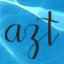

In [11]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

azt


In [13]:
tokenizer = GPT2Tokenizer.from_pretrained("NYTK/PULI-GPT-2")
class EnsembleForOCRPrediction(GPT2PreTrainedModel):
  def __init__(self, config):
      super().__init__(config)
      # combine the 2 models into 1
      # Get decoder part from TrOCR 
      # self.trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
      # self.decoder_1 = self.trocr_model.decoder
      # Or use 2 GPT-2 
      self.decoder_1 = GPT2Model.from_pretrained("NYTK/PULI-GPT-2") 
      self.decoder_2 = GPT2Model.from_pretrained("NYTK/PULI-GPT-2")
      #self.gpt2_layer = GPT2Model.from_pretrained('NYTK/PULI-GPT-2')
      self.cls = nn.Linear(2 * self.config.hidden_size, 2)     
      self.init_weights()
  
  def forward(
        self,
        input_ids = None,
        attention_mask = None,
        encoder_hidden_states = None,
        encoder_attention_mask = None,
        head_mask = None,
        cross_attn_head_mask = None,
        past_key_values = None,
        inputs_embeds = None,
        labels = None,
        use_cache = None,
        output_attentions = None,
        output_hidden_states = None,
        return_dict = None,
  ):
    

    input_ids = input_ids[0]
    # x1 = self.decoder_1(input_ids, encoder_hidden_states[-1])
    # x2 = self.decoder_2(input_ids, encoder_hidden_states[-1])

    #input_ids_1 = input_ids[0]
    #attention_mask_1 = attention_mask[0]
    #input_ids_2 = input_ids[0]
    #attention_mask_2 = attention_mask[1]
    #x1 = self.model_1(input_ids)
    #x2 = self.model_2(input_ids)
    #outputs = []
    
    #outputs.append(self.model_1(input_ids))

    #outputs.append(self.model_2(input_ids))

    # just get the [CLS] embeddings
    #  encoder_hidden_states=encoder_hidden_states
    logits_a = self.decoder_1(input_ids) #  encoder_last_hidden_states=encoder_last_hidden_states  
    logits_b = self.decoder_2(input_ids) #, encoder_hidden_states=encoder_hidden_states
    print('logits_a ',type(logits_a),logits_a)
    # print('logits_b' ,type(logits_b)) #,logits_b
    # print('logits_a[:0:] ',logits_a[:0:])
    # print('logits_b[:0:]',logits_b[:0:])
    last_hidden_states = torch.cat(logits_a[:0:], logits_b[:0:], 1)
    #last_hidden_states = torch.cat([output[1] for output in outputs], dim=1)
    logits = self.cls(last_hidden_states)
    return logits

Train a model

In [14]:
config  = GPT2Config.from_pretrained("NYTK/PULI-GPT-2")
# Initializing a GPT2 configuration
configuration = GPT2Config()
# Get encoder from original TrOCR 
# trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
# encoder = trocr_model .encoder
# Or 
encoder = ViTModel.from_pretrained('google/vit-base-patch32-384')
decoder = EnsembleForOCRPrediction(config)
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

Some weights of the model checkpoint at google/vit-base-patch32-384 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at NYTK/PULI-GPT-2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at NYTK/PULI-GPT-2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a m

In [15]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [16]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = 7
model.config.add_cross_attention = True
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

model.config.add_cross_attention = True
# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [17]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [18]:
cer_metric = load_metric("cer")
wer_metric = load_metric("wer")
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str) *100
    wer = wer_metric.compute(predictions=pred_str, references=label_str) *100
    return {"cer": cer}

<ipython-input-18-427e8ec2a76d>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [19]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    #tokenizer=processor.feature_extractor,
    tokenizer = tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


logits_a  <class 'transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions'> BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[ 0.3466, -0.0730,  0.4880,  ...,  0.3931, -0.1291,  0.2805],
        [ 0.1767,  1.5183, -0.2024,  ...,  1.4833, -0.4002, -0.1001],
        [ 0.4028,  0.1531,  0.5880,  ...,  0.2628, -0.6264, -0.5735],
        ...,
        [-0.1667,  0.8831,  0.4336,  ..., -0.7647,  0.2131,  1.2512],
        [-0.2011,  0.3094, -0.2505,  ..., -0.4142,  0.1871,  0.7024],
        [-0.1954,  0.8711,  0.1624,  ..., -0.5537, -0.1077,  0.7255]],
       device='cuda:0', grad_fn=<ViewBackward0>), past_key_values=((tensor([[[[-4.2310e-01, -2.7515e-01,  4.1406e-01,  ..., -4.5508e-01,
            3.4595e-01, -3.7646e-01],
          [-3.9902e-03,  3.8501e-01,  6.0364e-02,  ..., -3.6102e-02,
            1.2195e-01, -1.1877e-01],
          [ 3.1109e-03,  3.0566e-01, -5.8746e-02,  ...,  3.3844e-02,
            6.5735e-02, -8.2031e-02],
          ...,
          

TypeError: ignored

In [ ]:
trainer.save_model(output_dir="./model")

Evaluation and Inference

In [ ]:
model.eval()
with torch.no_grad():
    eval_result = trainer.evaluate(eval_dataset, max_length=64) 

In [ ]:
eval_result